In [1]:
pip install git+https://github.com/oracle/Skater.git

  Cloning https://github.com/oracle/Skater.git to d:\users\sbenabid\appdata\local\temp\pip-req-build-qgbsjac5
Note: you may need to restart the kernel to use updated packages.


  ERROR: Error [WinError 2] Le fichier spécifié est introuvable while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [2]:
#pip install shap

In [3]:
# pip install numba.core

## Exploration des données (vision d’ensemble sur les données) + Visualisation

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import re

In [3]:
# importation du DATASET 
#from google.colab import files

#uploaded = files.upload()

1    0.58828
0    0.41172
Name: Sentiment, dtype: float64

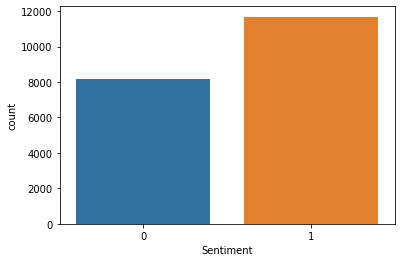

In [4]:
#à supprimer

df = pd.read_csv(r"C:\Users\kevin\0_projet_satisfaction_client\reviews_trust.csv")
df = df[["Commentaire", "star"]]
df["Sentiment"] = df["star"].apply(lambda x : np.where(x >=4 , 1 , 0))  # ajout de la colonne Sentiment à df
sns.countplot(df.Sentiment);
df["Sentiment"].value_counts(normalize = True) # léger déséquilibre des classes mais peut être traité comme un problème non déséquilibré

In [5]:
#Suppression des valeurs manquantes de la colonne Commentaire
df = df.dropna(axis = 0, how = 'any', subset =["Commentaire"])
df.reset_index(inplace = True)
df = df.drop(['index','star'],axis = 1)

In [8]:
#mettre les titres comme dans le rapport

## Modélisation - itération 1

## Prédire la satisfaction d’un client
Problème de classification (prédire le nombre d'étoiles).


## Text mining

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
#Nettoyages des commentaires et étapes de normalisation 

def find_exclamation(com):   #compte le nombre de points d'exclamation d'un commentaire
    r = re.compile(r"\!")
    exclamation = r.findall(com)
    return len(exclamation)

def find_interogation(com): #compte le nombre de points d'interogation d'un commentaire
    r = re.compile(r"\?")
    interogation = r.findall(com)
    return len(interogation)

def findCAPSLOCK(com):  #compte le nombre de caractères en majuscule d'un commentaire
    r = re.compile(r"[A-Z]")
    capslock = r.findall(com)
    return len(capslock)

def find_etc(com): #compte le nombre de chaine de ".." d'un commentaire
    r = re.compile(r"\.{2,}")
    etc = r.findall(com)
    return len(etc)

df["CAPSLOCK"]= df["Commentaire"].apply(lambda x : findCAPSLOCK(x))
df["exclamation"]= df["Commentaire"].apply(lambda x : find_exclamation(x))
df["interogation"]= df["Commentaire"].apply(lambda x : find_interogation(x))
df["chainpoints"]= df["Commentaire"].apply(lambda x : find_etc(x))
df['nb_caracter'] = df["Commentaire"].apply(len)
#Tokenization via RegexpTokenizer

from nltk.tokenize.regexp import RegexpTokenizer
tokenizer = RegexpTokenizer("[a-zA-Zéèê]{2,}")
df["preprocessed"] = df["Commentaire"].apply(lambda x : " ".join(x.lower() for x in str(x).strip().split()))

# On remplace les éèê par e
def remplacement_carac_e(com):
    text=re.sub(r"[éèêë]","e",com)
    return text
df["preprocessed"] = df["preprocessed"].apply(lambda x : remplacement_carac_e(x))

def neg_identify(text): 
    text = tokenizer.tokenize(text)
    for pos, word in enumerate(text) :
        if pos != len(text)-1 :
            if (word == 'ne' or word == "n" or word =="n'"):
                text[pos+1] = "NON_"+text[pos+1]
    text = " ".join(text)
    return (text)
df["preprocessed"] = df["preprocessed"].apply(lambda x : neg_identify(x))

# Déclaration des stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
stop_words.update (["!","?",".","_",":",",",";","-","--","...","'","...","'",',',',','…la','la','le','les','..','…','(',')','a+','+','etc…','qq','``',"j'","j '"])
# après une première visualisation des données, "commande" est très freqement apparu dans les 2 catégories et n'apporte à priori pas d'information sur la satisfaction du client"
# print(stop_words)

# Definition d'une fonction de filtrage de stopwords
def stopwords_filtering(chaine): # fonction renvoyant une liste ne contenant pas les stopwords
    tokens =[]
    chaine = tokenizer.tokenize(chaine)
    for mot in chaine :
        if mot not in stop_words :#conservation des mots non stopwords 
            tokens.append(mot)
    tokens = " ".join(tokens)
    return tokens
df["preprocessed"] = df["preprocessed"].apply(lambda x : stopwords_filtering(x))

# Opération de stemming

from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
def  stemming(text) :
    text = tokenizer.tokenize(text)
    stemmed_text = ""
    for mot in text: 
        stem = stemmer.stem(mot)
        stemmed_text =  stemmed_text +" "+ stem
    return  stemmed_text

df["preprocessed"] = df["preprocessed"].apply(lambda x: stemming(x))


In [8]:
df["Commentaire"]

0        Bonjour , Ca doit faire 5 ans environ que je s...
1        Vente lacoste article manquant photo prise sur...
2        Vente Lacoste Honteuse , article erroné , arti...
3        J'ai commandé des mules de la marque Moosefiel...
4        Commande téléphone etat A+ . Livraison d un vi...
                               ...                        
19829                                      Pas de probleme
19830    Cliente depuis 2008 sans encombre jusqu ' à ju...
19831    Je ne sais pas si VP cherche à vendre ou à fai...
19832    Je suis client sur ce site depuis plusieurs an...
19833    J'ai achetée une offre photobox via le site ve...
Name: Commentaire, Length: 19834, dtype: object

In [416]:
#séparation des données pour l'analyse des sentiments
X = df.drop(["Commentaire", "Sentiment"] , axis=1)
y = df["Sentiment"]

## Analyse de sentiments 

### Méthode BOW (Bag of words) CountVectorizer

In [417]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

In [418]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB #Particulièrement adapté aux problèmes de classification avec des features discretes (text classification)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [12]:
# ##  Algorithmes de classification sans tunning d'hyperparamètres
# - Régression logistique
# - SVM
# - Naïve Bayes
# - GradientBoosting
# Vectorisation prenant en compte uniquement les unigrams (vectorisation mot / mot)

In [13]:
%%time
from scipy.sparse import hstack
import time 
# Vectorization avec CountVectorizer ()
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence


X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# instanciation des classifieurs

clf_reglog_unigram = LogisticRegression(C=1, max_iter= 10000)

clf_svc_unigram = SVC(probability=True)

clf_MNB_unigram = MultinomialNB() 

clf_GB_unigram = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog_unigram:", end-start)
# start = time.time()
# clf_svc_unigram.fit(X_train, y_train)
# end = time.time()
# print("The time of clf_svc_unigram:", end-start)
# start = time.time()
clf_MNB_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_MNB_unigram:", end-start)
start = time.time()
clf_GB_unigram.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB_unigram:", end-start)


The time of clf_reglog_unigram: 0.21053481101989746
The time of clf_MNB_unigram: 0.2145240306854248
The time of clf_GB_unigram: 3.2402737140655518
Wall time: 3.8 s


In [17]:
%%time
# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_unigram.score(X_test,y_test))
# print(" -- SVC --")
# print("Score sur le trainset :",clf_svc_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_unigram.score(X_test,y_test))
# print(" -- Multinomial Naïve Bayes --")
# print("Score sur le trainset :",clf_MNB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_unigram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_unigram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9243083128505704 ; Score sur le testset :  0.8850516763297201
 -- GradientBoosting -- 
Score sur le trainset : 0.8660112182517175 ; Score sur le testset :  0.8565666750693219
Wall time: 47 ms


In [18]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog_unigram = clf_reglog_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog_unigram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog_unigram))


 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,1318,334
1,122,2193


              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1652
           1       0.87      0.95      0.91      2315

    accuracy                           0.89      3967
   macro avg       0.89      0.87      0.88      3967
weighted avg       0.89      0.89      0.88      3967

Wall time: 26 ms


## Interprétabilité de régression logistique unigram

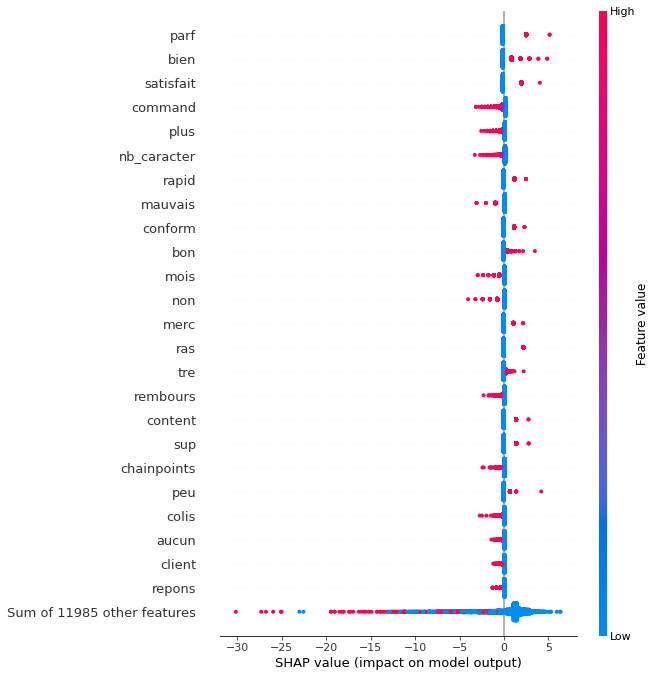

In [19]:
import shap
features =  vec_unigram.get_feature_names() + ['CAPSLOCK', 'exclamation','interogation','chainpoints','nb_caracter']
explainer = shap.LinearExplainer(clf_reglog_unigram,X_train)
x = X_test.toarray()
x_test = pd.DataFrame(x, columns=features)
shap_values = explainer(x_test)
figure = plt.figure(figsize=(10,10))
shap.plots.beeswarm(shap_values,max_display=25)


In [20]:
# print(" -- SVC --")
# pred_clf_svc_unigram = clf_svc_unigram.predict(X_test)
# display(pd.crosstab(y_test, pred_clf_svc_unigram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
# print(classification_report(y_test,pred_clf_svc_unigram))


### Interpretabilite de SVC


In [21]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

# def svc_predict_X(x):
#     return clf_svc_unigram.predict_proba(x)

In [22]:
# interpreter = Interpretation(X_train.toarray(), feature_names=features)
# model = InMemoryModel(svc_predict_X, examples = X_train.toarray())

In [23]:
#interpreter.feature_importance.plot_feature_importance(model, ascending=True)
#cela prend à peu prés 4 jours pour l'exécuter 
#si on essaie de prendre que des échantillions, l'interprétabilité ne va pas être précise.

In [24]:
# print(" -- Multinomial Naïve Bayes --")
# pred_clf_MNB_unigram = clf_MNB_unigram.predict(X_test)
# display(pd.crosstab(y_test, pred_clf_MNB_unigram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
# print(classification_report(y_test,pred_clf_MNB_unigram))
print("l'exécution dee l'interprétation de ces deux modèles est trés longue")

l'exécution dee l'interprétation de ces deux modèles est trés longue


### Interpretabilite de Multinomial naive Bayes


In [25]:
# from skater.core.explanations import Interpretation
# from skater.model import InMemoryModel

# def predict_X(x):
#     return clf_MNB_unigram.predict_proba(x)


In [26]:
# interpreter = Interpretation(X_train.toarray(), feature_names=features)
# model = InMemoryModel(predict_X, examples = X_train.toarray())

In [27]:
#interpreter.feature_importance.plot_feature_importance(model, ascending=True)
#ça prend bcp de temps pour l'excéuter
#si on essaie de prendre que des échantillions, l'interprétabilité ne sera précise.

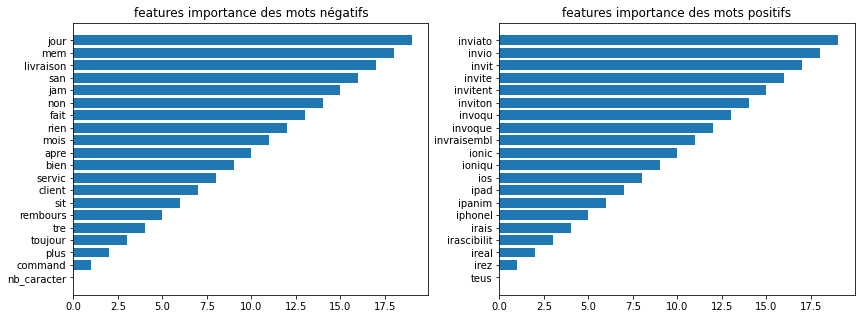

In [28]:
plt.figure(figsize=(14,5))
neg_class_prob_sorted = clf_MNB_unigram.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = clf_MNB_unigram.feature_log_prob_[1, :].argsort()[::1]

feauture_amount = 20
neg_class_prob_feature = np.take(features, neg_class_prob_sorted[:feauture_amount])
pos_class_prob_feature = np.take(features, pos_class_prob_sorted[:feauture_amount])
plt.subplot(121)
plt.barh(neg_class_prob_feature, sorted(list(neg_class_prob_sorted))[:feauture_amount])
plt.title("features importance des mots négatifs");
plt.subplot(122)
plt.barh(pos_class_prob_feature, sorted(list(pos_class_prob_sorted))[:feauture_amount])
plt.title("features importance des mots positifs");

In [29]:
#list(neg_class_prob_sorted).plot.barh()

In [30]:
print(np.take(features, neg_class_prob_sorted[:10]))
print(np.take(features, pos_class_prob_sorted[:10]))

['nb_caracter' 'command' 'plus' 'toujour' 'tre' 'rembours' 'sit' 'client'
 'servic' 'bien']
['teus' 'irez' 'ireal' 'irascibilit' 'irais' 'iphonel' 'ipanim' 'ipad'
 'ios' 'ioniqu']


## Interprétabilité GBS

In [31]:
print(" -- GradientBoosting -- ")
pred_clf_GB_unigram = clf_GB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB_unigram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB_unigram))

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,1276,376
1,193,2122


              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1652
           1       0.85      0.92      0.88      2315

    accuracy                           0.86      3967
   macro avg       0.86      0.84      0.85      3967
weighted avg       0.86      0.86      0.86      3967



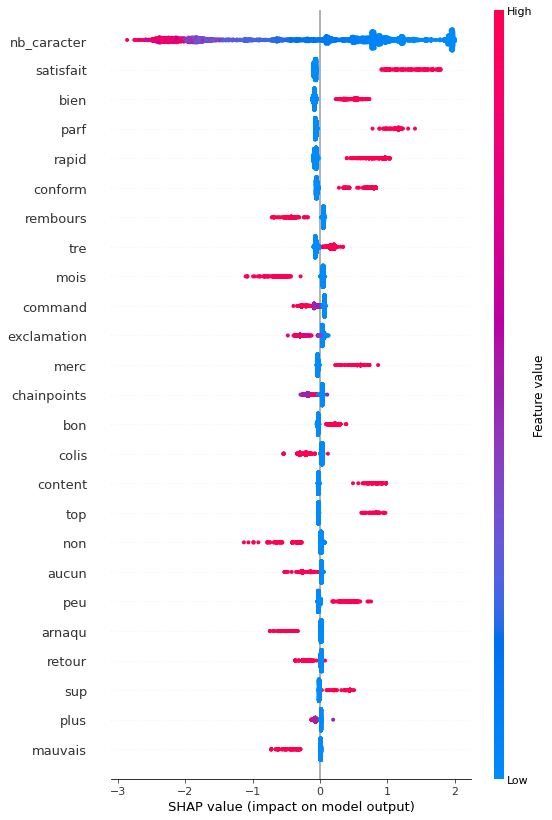

In [32]:
import shap
explainer = shap.TreeExplainer(clf_GB_unigram)
x = X_test.toarray()
x_test = pd.DataFrame(x, columns=features)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, max_display=25)

In [33]:
# ##  Algorithmes de classification sans tunning d'hyperparamètres
# - Régression logistique
# - SVM
# - Naïve Bayes
# - GradientBoosting
# Vectorisation prenant en compte des ngrams (1 à 2)

In [34]:
%%time
import time 
# Vectorization avec CountVectorizer ()

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# instanciation des classifieurs 
clf_reglog_ngram = LogisticRegression(C=1, max_iter= 10000)
clf_svc_ngram = SVC()
clf_MNB_ngram = MultinomialNB() 
clf_GB_ngram = GradientBoostingClassifier() 

# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog_ngram.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog_ngram:", end-start)
start = time.time()
clf_svc_ngram.fit(X_train, y_train)
end = time.time()
print("The time of clf_svc_ngram:", end-start)
start = time.time()
clf_MNB_ngram.fit(X_train, y_train)
end = time.time()
print("The time of clf_MNB_ngram:", end-start)
start = time.time()
clf_GB_ngram.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB_ngram:", end-start)



The time of clf_reglog_ngram: 1.841965913772583
The time of clf_svc_ngram: 107.96743154525757
The time of clf_MNB_ngram: 0.01703619956970215
The time of clf_GB_ngram: 18.709728479385376
Wall time: 2min 9s


In [35]:
%%time
# Affichage des scores des différents classifieurs
print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_ngram.score(X_test,y_test))
print(" -- SVC --")
print("Score sur le trainset :",clf_svc_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_ngram.score(X_test,y_test))
print(" -- Multinomial Naïve Bayes --")
print("Score sur le trainset :",clf_MNB_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_ngram.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB_ngram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_ngram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9802735236654692 ; Score sur le testset :  0.8890849508444668
 -- SVC --
Score sur le trainset : 0.9521018465998613 ; Score sur le testset :  0.8661457020418453
 -- Multinomial Naïve Bayes --
Score sur le trainset : 0.9440347891851012 ; Score sur le testset :  0.8830350390723468
 -- GradientBoosting -- 
Score sur le trainset : 0.8673347198588265 ; Score sur le testset :  0.8540458784976053
Wall time: 1min 14s


In [36]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog_ngram = clf_reglog_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog_ngram))
#print(" -- SVC --")
pred_clf_svc_ngram = clf_svc_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_svc_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_svc_ngram))
print(" -- Multinomial Naïve Bayes --")
pred_clf_MNB_ngram = clf_MNB_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_MNB_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_MNB_ngram))
print(" -- GradientBoosting -- ")
pred_clf_GB_ngram = clf_GB_ngram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB_ngram,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB_ngram))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,1348,304
1,136,2179


              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1652
           1       0.88      0.94      0.91      2315

    accuracy                           0.89      3967
   macro avg       0.89      0.88      0.88      3967
weighted avg       0.89      0.89      0.89      3967



Classe réelle,0,1
Classe prédite,,
0,1212,440
1,91,2224


              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1652
           1       0.83      0.96      0.89      2315

    accuracy                           0.87      3967
   macro avg       0.88      0.85      0.86      3967
weighted avg       0.87      0.87      0.86      3967

 -- Multinomial Naïve Bayes --


Classe réelle,0,1
Classe prédite,,
0,1414,238
1,226,2089


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1652
           1       0.90      0.90      0.90      2315

    accuracy                           0.88      3967
   macro avg       0.88      0.88      0.88      3967
weighted avg       0.88      0.88      0.88      3967

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,1273,379
1,200,2115


              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1652
           1       0.85      0.91      0.88      2315

    accuracy                           0.85      3967
   macro avg       0.86      0.84      0.85      3967
weighted avg       0.85      0.85      0.85      3967

Wall time: 12.4 s


In [37]:
### Mise au point du modèle Multinomial Naïve Bayes (prenant en compte uniquement des unigrams)

In [15]:
%%time
from scipy.sparse import hstack
import time 
# Vectorization avec CountVectorizer ()
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Wall time: 351 ms


###  GridSearch

In [39]:

#GridSearchCV va nous permettre de tester une série de paramètres et de comparer 
#les performances pour en déduire le meilleur paramétrage.
from sklearn.model_selection import GridSearchCV
params = {"alpha": np.linspace(1e-10,1,30)}
grid_MN = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN.best_params_, "permettant d'obtenir un score de " , grid_MN.best_score_)
print("Score sur le trainset :",grid_MN.score(X_train,y_train),"; Score sur le testset : ",grid_MN.score(X_test,y_test))
print("On ne fait à priori pas face à un problème d'overfiting")

Meilleur paramètre :  {'alpha': 0.9655172413827586} permettant d'obtenir un score de  0.8606546930018185
Score sur le trainset : 0.8851704796117729 ; Score sur le testset :  0.8711872951852786
On ne fait à priori pas face à un problème d'overfiting


In [ ]:
# Best score training

In [18]:
# Best score training
import time

start = time.time()
clf_MNB_bow = MultinomialNB(alpha=0.9655172413827586)
clf_MNB_bow.fit(X_train,y_train)
end = time.time()

print("Durée d'entraînement :", end - start, "secondes")

Durée d'entraînement : 0.0049588680267333984 secondes


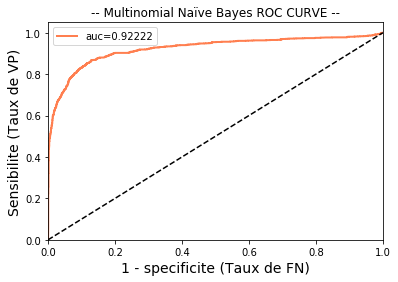

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1652
           1       0.87      0.92      0.89      2315

    accuracy                           0.87      3967
   macro avg       0.87      0.86      0.87      3967
weighted avg       0.87      0.87      0.87      3967



In [19]:
#La prédiction
from sklearn.metrics import classification_report
y_pred_MNB_bow_proba = clf_MNB_bow.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_MNB_bow_proba[:,0], pos_label= 0)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

y_pred_MNB_bow = clf_MNB_bow.predict(X_test)
print(classification_report(y_test, y_pred_MNB_bow))

In [41]:
### Mise au point du modèle Multinomial Naïve Bayes (prenant en compte les  unigrams & bigrams)

In [42]:
# Vectorization avec CountVectorizer ()

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


params = {"alpha": np.linspace(1e-10,1,30)}
grid_MN_ngram = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN_ngram.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN_ngram.best_params_, "permettant d'obtenir un score de " , grid_MN_ngram.best_score_)
print("Score sur le trainset :",grid_MN_ngram.score(X_train,y_train),"; Score sur le testset : ",grid_MN_ngram.score(X_test,y_test))
print("On fait probablement face à un problème d'overfiting")


Meilleur paramètre :  {'alpha': 1.0} permettant d'obtenir un score de  0.862482377797385
Score sur le trainset : 0.9440347891851012 ; Score sur le testset :  0.8830350390723468
On fait probablement face à un problème d'overfiting


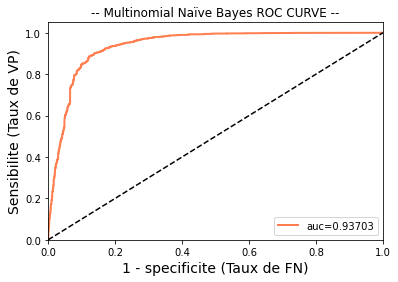

In [43]:
y_pred_MNB_ngram = grid_MN_ngram.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_MNB_ngram[:,1], pos_label= 1)
aucf= auc(fpr, tpr)
plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();



In [44]:
### Mise au point du modèle Regression logistique (prenant en compte uniquement des unigrams)

In [11]:
%%time
from scipy.sparse import hstack
import time 
# Vectorization avec CountVectorizer ()
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define models and parameters
model = LogisticRegression(max_iter= 500)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
C = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=C)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_lr = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_lr.best_score_, grid_lr.best_params_))
means = grid_lr.cv_results_['mean_test_score']
stds = grid_lr.cv_results_['std_test_score']
params = grid_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.878931 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.864939 (0.007494) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.865002 (0.007433) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.865002 (0.007433) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.878931 (0.006690) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.878931 (0.006690) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.878931 (0.006690) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.878616 (0.003315) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.878616 (0.003315) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.878553 (0.003279) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.855235 (0.003758) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.855235 (0.003608) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.855802 (0.003635) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.796685 (0.005063) with

In [15]:
# Best score training
import time

start = time.time()
clf_lr_bow = LogisticRegression(max_iter= 500, C = 10, penalty = 'l2', solver = 'newton-cg')
clf_lr_bow.fit(X_train,y_train)
end = time.time()

print("Durée d'entraînement :", end - start, "secondes")

Durée d'entraînement : 0.3575432300567627 secondes


In [16]:
print("Score sur le trainset :",clf_lr_bow.score(X_train,y_train),"; Score sur le testset : ",clf_lr_bow.score(X_test,y_test))

Score sur le trainset : 0.9551269931303964 ; Score sur le testset :  0.8820267204436602


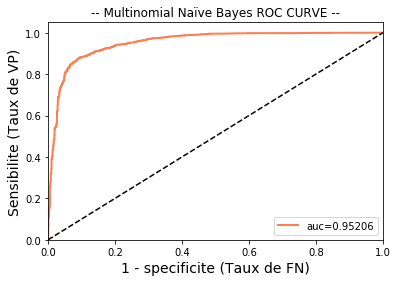

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1652
           1       0.88      0.93      0.90      2315

    accuracy                           0.88      3967
   macro avg       0.88      0.87      0.88      3967
weighted avg       0.88      0.88      0.88      3967



In [20]:
y_pred_lr_proba = clf_lr_bow.predict_proba(X_test)

from sklearn.metrics import auc, roc_curve
from sklearn.metrics import classification_report

fpr , tpr , seuil = roc_curve(y_test, y_pred_lr_proba[:,1], pos_label= 1)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();


y_pred_lr = clf_lr_bow.predict(X_test)
print(classification_report(y_test, y_pred_lr))

In [48]:
### Mise au point du modèle de regression logistique (prenant en compte les  unigrams & bigrams)

In [49]:
%%time

# Vectorization avec CountVectorizer ()

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define models and parameters
model = LogisticRegression(max_iter= 500)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
C = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=C)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_lr = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_lr.best_score_, grid_lr.best_params_))
means = grid_lr.cv_results_['mean_test_score']
stds = grid_lr.cv_results_['std_test_score']
params = grid_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.885423 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.878679 (0.005617) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.878679 (0.005617) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.878364 (0.005731) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.885423 (0.003168) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.885360 (0.003205) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.885423 (0.003168) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.885423 (0.001809) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.885423 (0.001809) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.885297 (0.001834) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.863553 (0.002488) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.863553 (0.002488) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.863554 (0.002685) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.809542 (0.003402) with

In [50]:
print("Score sur le trainset :",grid_lr.score(X_train,y_train),"; Score sur le testset : ",grid_lr.score(X_test,y_test))

Score sur le trainset : 0.9913657276107645 ; Score sur le testset :  0.8911015881018401


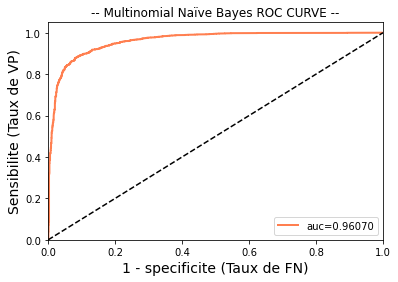

In [51]:
y_pred_lr = grid_lr.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_lr[:,1], pos_label= 1)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();


In [52]:
###  Mise au point du modèle SVC (prenant en compte uniquement des unigrams)

In [53]:
%%time

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define models and parameters
model = SVC(probability= True)
kernel = ['linear','poly', 'rbf', 'sigmoid']
gamma = ['scale']
C = [1,10,20,30,40,50]
grid = dict(kernel=kernel,C=C,gamma=gamma)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_svc = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))
means = grid_svc.cv_results_['mean_test_score']
stds = grid_svc.cv_results_['std_test_score']
params = grid_svc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.876725 using {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.876725 (0.004251) with: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.658789 (0.004179) with: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.870990 (0.006954) with: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.872818 (0.003582) with: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.865885 (0.005114) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.717905 (0.002251) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.869540 (0.005991) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.868784 (0.008378) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.862293 (0.005947) with: {'C': 20, 'gamma': 'scale', 'kernel': 'linear'}
0.734544 (0.005740) with: {'C': 20, 'gamma': 'scale', 'kernel': 'poly'}
0.865318 (0.005622) with: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}
0.863995 (0.006768) with: {'C': 20, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.859268 (0.007513) with: {'C': 30, 'gamma': 'scale', 'kerne

In [54]:
print("Score sur le trainset :",grid_svc.score(X_train,y_train),"; Score sur le testset : ",grid_svc.score(X_test,y_test))

Score sur le trainset : 0.942711287577992 ; Score sur le testset :  0.8817746407864885


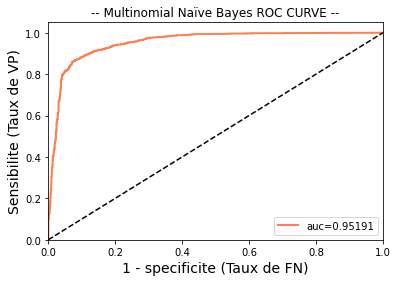

In [55]:
y_pred_svc = grid_svc.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_svc[:,1], pos_label= 1)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();


In [56]:
### Mise au point du modèle SVC (prenant en compte les  unigrams & bigrams)

In [57]:
%%time

# Vectorization avec CountVectorizer ()

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_ngram = CountVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define models and parameters
model = SVC(probability = True)
kernel = ['linear','rbf']
gamma = ['scale']
C = [1,10,20]
grid = dict(kernel=kernel,C=C,gamma=gamma)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_svc = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))
means = grid_svc.cv_results_['mean_test_score']
stds = grid_svc.cv_results_['std_test_score']
params = grid_svc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.872755 using {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.872755 (0.004048) with: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.860087 (0.005424) with: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.858827 (0.003661) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.872125 (0.003561) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.854919 (0.003403) with: {'C': 20, 'gamma': 'scale', 'kernel': 'linear'}
0.871684 (0.003728) with: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}
Wall time: 44min 3s


In [58]:
print("Score sur le trainset :",grid_svc.score(X_train,y_train),"; Score sur le testset : ",grid_svc.score(X_test,y_test))

Score sur le trainset : 0.9897271065733914 ; Score sur le testset :  0.8774892866145702


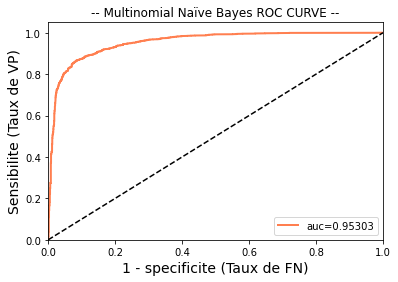

In [59]:
y_pred_svc = grid_svc.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_svc[:,1], pos_label= 1)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();


In [60]:
###  Mise au point du modèle GradientBoosting (prenant en compte uniquement des unigrams)

In [61]:
%%time
from sklearn.model_selection import GridSearchCV

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_unigram = CountVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#test hyperparamètres 1
# params_1 = {'learning_rate':[0.01,0.05,0.1,0.13,0.14], 'n_estimators':[1750,2000,2500,3000]}
# params_2 = {'n_estimators':[3000, 4000,7000]}
# params_3 = {'max_depth':[7,8,10,12] }
# params_4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}
params_5 = {'max_features':[2,3,4,5,6,7]}

model = GradientBoostingClassifier(learning_rate = 0.14 ,n_estimators = 4000, max_depth = 7, min_samples_leaf=1, min_samples_split = 2, subsample=1, random_state=0)

# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=params_5, n_jobs=-1, cv=5, scoring='accuracy')
#grid_svc = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_svc.best_score_, grid_svc.best_params_))
means = grid_svc.cv_results_['mean_test_score']
stds = grid_svc.cv_results_['std_test_score']
params = grid_svc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print('Accuracy of the GBM ontrain set: {:.3f}'.format(grid_svc.score(X_train, y_train)))
print('Accuracy of the GBM on test set: {:.3f}'.format(grid_svc.score(X_test, y_test)))

print("Score sur le trainset :",grid_svc.score(X_train,y_train),"; Score sur le testset : ",grid_svc.score(X_test,y_test))

y_pred_GB=grid_svc.predict(X_test)


print(classification_report(y_test, y_pred_GB))

Best: 0.872755 using {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.872755 (0.004048) with: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
0.860087 (0.005424) with: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.858827 (0.003661) with: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.872125 (0.003561) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.854919 (0.003403) with: {'C': 20, 'gamma': 'scale', 'kernel': 'linear'}
0.871684 (0.003728) with: {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}


ValueError: X.shape[1] = 12009 should be equal to 155709, the number of features at training time

In [62]:
#ajouter l'interprétabilité Gridsearch Gradient boosting ici


## Méthode TF-IDF

In [63]:
#rajouter l'interprétabilité

In [64]:
# ##  Algorithmes de classification sans tunning d'hyperparamètres
# - Régression logistique
# - SVM
# - Naïve Bayes
# - GradientBoosting
# Vectorisation prenant en compte uniquement les unigrams (vectorisation mot / mot)


In [21]:
%%time 
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

vec_unigram = TfidfVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# # instanciation des classifieurs 
# clf_reglog_unigram = LogisticRegression(C=1, max_iter= 10000)
# #clf_svc_unigram = SVC()
# #clf_MNB_unigram = MultinomialNB() 
# clf_GB_unigram = GradientBoostingClassifier()

# # Fit des classifieurs aux données d'entraînement
# start = time.time()
# clf_reglog_unigram.fit(X_train, y_train)
# end = time.time()
# print("The time of clf_reglog_unigram:", end-start)
# start = time.time()
# clf_svc_unigram.fit(X_train, y_train)
# end = time.time()
# #print("The time of clf_svc_unigram:", end-start)
# start = time.time()
# clf_MNB_unigram.fit(X_train, y_train)
# end = time.time()
# #print("The time of clf_MNB_unigram:", end-start)
# start = time.time()
# clf_GB_unigram.fit(X_train, y_train)
# end = time.time()
# print("The time of clf_GB_unigram:", end-start)

Wall time: 344 ms


In [66]:
# %%time
# # Affichage des scores des différents classifieurs

# print(" -- Régression logistique --")
# print("Score sur le trainset :",clf_reglog_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_reglog_unigram.score(X_test,y_test))
# #print(" -- SVC --")
# #print("Score sur le trainset :",clf_svc_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_svc_unigram.score(X_test,y_test))
# #print(" -- Multinomial Naïve Bayes --")
# print("Score sur le trainset :",clf_MNB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_MNB_unigram.score(X_test,y_test))
# print(" -- GradientBoosting -- ")
# print("Score sur le trainset :",clf_GB_unigram.score(X_train,y_train),"; Score sur le testset : ",clf_GB_unigram.score(X_test,y_test))

 -- Régression logistique --
Score sur le trainset : 0.9378584483519253 ; Score sur le testset :  0.8931182253592135
Score sur le trainset : 0.8934896325707443 ; Score sur le testset :  0.8699268968994203
 -- GradientBoosting -- 
Score sur le trainset : 0.8699186991869918 ; Score sur le testset :  0.8568187547264936
Wall time: 68 ms


In [67]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog = clf_reglog_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog))
print(" -- SVC --")
pred_clf_svc = clf_svc_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_svc,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_svc))
print(" -- Multinomial Naïve Bayes --")
pred_clf_MNB = clf_MNB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_MNB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_MNB))
print(" -- GradientBoosting -- ")
pred_clf_GB = clf_GB_unigram.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,1413,239
1,185,2130


              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1652
           1       0.90      0.92      0.91      2315

    accuracy                           0.89      3967
   macro avg       0.89      0.89      0.89      3967
weighted avg       0.89      0.89      0.89      3967

 -- SVC --


Classe réelle,0,1
Classe prédite,,
0,1486,166
1,353,1962


              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1652
           1       0.92      0.85      0.88      2315

    accuracy                           0.87      3967
   macro avg       0.87      0.87      0.87      3967
weighted avg       0.87      0.87      0.87      3967

 -- Multinomial Naïve Bayes --


Classe réelle,0,1
Classe prédite,,
0,1369,283
1,233,2082


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1652
           1       0.88      0.90      0.89      2315

    accuracy                           0.87      3967
   macro avg       0.87      0.86      0.87      3967
weighted avg       0.87      0.87      0.87      3967

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,1283,369
1,199,2116


              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1652
           1       0.85      0.91      0.88      2315

    accuracy                           0.86      3967
   macro avg       0.86      0.85      0.85      3967
weighted avg       0.86      0.86      0.86      3967

Wall time: 11.9 s


In [68]:
# #### Classification à l'aide des algorithmes : 
# - Régression logistique
# - SVM
# - Naïve Bayes
# - GradientBoosting
# Vectorisation prenant en compte des unigrams et bigrams

In [69]:
%%time 

df_train, df_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 0)

vec_ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,2)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_ngram.fit_transform(df_train.preprocessed)
X_test_text = vec_ngram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# instanciation des classifieurs 
clf_reglog = LogisticRegression(C=1, max_iter= 5000)
clf_svc = SVC()
clf_MNB= MultinomialNB() 
clf_GB = GradientBoostingClassifier()

# Fit des classifieurs aux données d'entraînement
start = time.time()
clf_reglog.fit(X_train, y_train)
end = time.time()
print("The time of clf_reglog_unigram:", end-start)
start = time.time()
clf_svc.fit(X_train, y_train)
end = time.time()
print("The time of clf_svc_unigram:", end-start)
start = time.time()
clf_MNB.fit(X_train, y_train)
end = time.time()
print("The time of clf_MNB_unigram:", end-start)
start = time.time()
clf_GB.fit(X_train, y_train)
end = time.time()
print("The time of clf_GB_unigram:", end-start)

# Affichage des scores des différents classifieurs

print(" -- Régression logistique --")
print("Score sur le trainset :",clf_reglog.score(X_train,y_train),"; Score sur le testset : ",clf_reglog.score(X_test,y_test))
print(" -- SVC --")
print("Score sur le trainset :",clf_svc.score(X_train,y_train),"; Score sur le testset : ",clf_svc.score(X_test,y_test))
print(" -- Multinomial Naïve Bayes --")
print("Score sur le trainset :",clf_MNB.score(X_train,y_train),"; Score sur le testset : ",clf_MNB.score(X_test,y_test))
print(" -- GradientBoosting -- ")
print("Score sur le trainset :",clf_GB.score(X_train,y_train),"; Score sur le testset : ",clf_GB.score(X_test,y_test))

The time of clf_reglog_unigram: 3.3686611652374268
The time of clf_svc_unigram: 250.35195565223694
The time of clf_MNB_unigram: 0.04876995086669922
The time of clf_GB_unigram: 54.05062174797058
 -- Régression logistique --
Score sur le trainset : 0.9845591479170606 ; Score sur le testset :  0.8968994202167885
 -- SVC --
Score sur le trainset : 0.9638873132917376 ; Score sur le testset :  0.8419460549533653
 -- Multinomial Naïve Bayes --
Score sur le trainset : 0.9494548433856431 ; Score sur le testset :  0.8757247290143685
 -- GradientBoosting -- 
Score sur le trainset : 0.8729438457175269 ; Score sur le testset :  0.8605999495840686
Wall time: 7min 7s


In [71]:
%%time
# Affichage des prédictions par les différents classifieurs
print(" -- Régression logistique --")
pred_clf_reglog = clf_reglog.predict(X_test)
display(pd.crosstab(y_test, pred_clf_reglog,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_reglog))
print(" -- SVC --")
pred_clf_svc = clf_svc.predict(X_test)
display(pd.crosstab(y_test, pred_clf_svc,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_svc))
print(" -- Multinomial Naïve Bayes --")
pred_clf_MNB = clf_MNB.predict(X_test)
display(pd.crosstab(y_test, pred_clf_MNB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_MNB))
print(" -- GradientBoosting -- ")
pred_clf_GB = clf_GB.predict(X_test)
display(pd.crosstab(y_test, pred_clf_GB,  colnames=["Classe réelle"], rownames=["Classe prédite"]))
print(classification_report(y_test,pred_clf_GB))

 -- Régression logistique --


Classe réelle,0,1
Classe prédite,,
0,1436,216
1,193,2122


              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1652
           1       0.91      0.92      0.91      2315

    accuracy                           0.90      3967
   macro avg       0.89      0.89      0.89      3967
weighted avg       0.90      0.90      0.90      3967

 -- SVC --


Classe réelle,0,1
Classe prédite,,
0,1507,145
1,482,1833


              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1652
           1       0.93      0.79      0.85      2315

    accuracy                           0.84      3967
   macro avg       0.84      0.85      0.84      3967
weighted avg       0.86      0.84      0.84      3967

 -- Multinomial Naïve Bayes --


Classe réelle,0,1
Classe prédite,,
0,1408,244
1,249,2066


              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1652
           1       0.89      0.89      0.89      2315

    accuracy                           0.88      3967
   macro avg       0.87      0.87      0.87      3967
weighted avg       0.88      0.88      0.88      3967

 -- GradientBoosting -- 


Classe réelle,0,1
Classe prédite,,
0,1295,357
1,196,2119


              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1652
           1       0.86      0.92      0.88      2315

    accuracy                           0.86      3967
   macro avg       0.86      0.85      0.85      3967
weighted avg       0.86      0.86      0.86      3967

Wall time: 24.9 s


In [419]:
%%time 
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()


vec_unigram = TfidfVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Wall time: 434 ms


In [16]:
#GridSearchCV va nous permettre de tester une série de paramètres et de comparer 
#les performances pour en déduire le meilleur paramétrage.
from sklearn.model_selection import GridSearchCV
params = {"alpha": np.linspace(1e-10,1,30)}
grid_MN = GridSearchCV(MultinomialNB(), cv= 5, param_grid = params)
grid_MN.fit(X_train, y_train)
print("Meilleur paramètre : ", grid_MN.best_params_, "permettant d'obtenir un score de " , grid_MN.best_score_)
print("Score sur le trainset :",grid_MN.score(X_train,y_train),"; Score sur le testset : ",grid_MN.score(X_test,y_test))
print("On ne fait à priori pas face à un problème d'overfiting")

Meilleur paramètre :  {'alpha': 0.5862068965931034} permettant d'obtenir un score de  0.8626083421655345
Score sur le trainset : 0.8999810928341841 ; Score sur le testset :  0.8686664986135619
On ne fait à priori pas face à un problème d'overfiting


In [17]:
# Best score training
import time

start = time.time()
clf_MNB_tfidf = MultinomialNB(alpha=0.5862068965931034)
clf_MNB_tfidf.fit(X_train,y_train)
end = time.time()

print("Durée d'entraînement :", end - start, "secondes")

Durée d'entraînement : 0.0049855709075927734 secondes


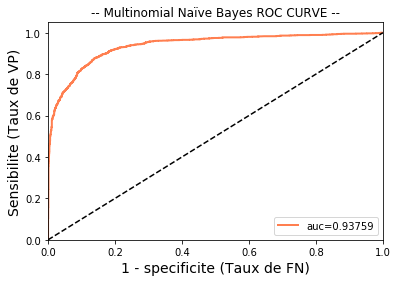

NameError: name 'y_pred_MNB_bow' is not defined

In [19]:
# Prédiction
from sklearn.metrics import classification_report
y_pred_MNB_tfidf_proba = clf_MNB_tfidf.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_MNB_tfidf_proba[:,0], pos_label= 0)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

y_pred_MNB_tfidf = clf_MNB_tfidf.predict(X_test)
print(classification_report(y_test, y_pred_MNB_bow))

In [576]:
%%time 
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

vec_unigram = TfidfVectorizer(analyzer='word', ngram_range=(1,1)) #stopwords déjà supprimés dans le prétraitement
X_train_text = vec_unigram.fit_transform(df_train.preprocessed)
X_test_text = vec_unigram.transform(df_test.preprocessed)
#on ajoute les metadonnées standardisées à notre vecteur d'occurence

X_train = hstack([X_train_text,df_train.drop("preprocessed", axis=1).values])
X_test = hstack([X_test_text,df_test.drop("preprocessed", axis=1).values])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Wall time: 473 ms


<15867x12009 sparse matrix of type '<class 'numpy.float64'>'
	with 299573 stored elements in Compressed Sparse Row format>

In [15]:
#GridSearchCV va nous permettre de tester une série de paramètres et de comparer 
#les performances pour en déduire le meilleur paramétrage.
# define models and parameters
model = LogisticRegression(max_iter= 500)
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
C = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=C)
# define grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_lr = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_lr.best_score_, grid_lr.best_params_))
means = grid_lr.cv_results_['mean_test_score']
stds = grid_lr.cv_results_['std_test_score']
params = grid_lr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


NameError: name 'GridSearchCV' is not defined

In [578]:
# Best score training
from joblib import dump, load
import time

start = time.time()
clf_lr_tfidf = LogisticRegression(max_iter= 500, C = 1.0, penalty = 'l2', solver = 'liblinear')
clf_lr_tfidf.fit(X_train,y_train)
end = time.time()

print("Durée d'entraînement :", end - start, "secondes")

dump(clf_lr_tfidf,'clf_lr_tfidf.joblib')

Durée d'entraînement : 0.0784459114074707 secondes


['clf_lr_tfidf.joblib']

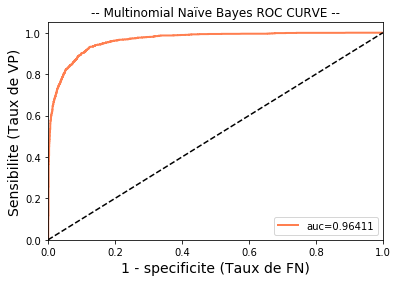

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1652
           1       0.90      0.92      0.91      2315

    accuracy                           0.90      3967
   macro avg       0.89      0.89      0.89      3967
weighted avg       0.90      0.90      0.90      3967



In [443]:
# Prédiction
from sklearn.metrics import classification_report
y_pred_lr_tfidf_proba = clf_lr_tfidf.predict_proba(X_test)
from sklearn.metrics import auc, roc_curve

fpr , tpr , seuil = roc_curve(y_test, y_pred_lr_tfidf_proba[:,0], pos_label= 0)
aucf= auc(fpr, tpr)

plt.plot(fpr, tpr, color='coral', lw=2, label ='auc=%1.5f' % aucf)
plt.plot([0, 1], [0, 1], 'k--')
plt.title("-- Multinomial Naïve Bayes ROC CURVE --")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite (Taux de FN)', fontsize=14)
plt.ylabel('Sensibilite (Taux de VP)', fontsize=14)
plt.legend();
plt.show();

y_pred_lr_tfidf = clf_lr_tfidf.predict(X_test)
print(classification_report(y_test, y_pred_lr_tfidf))

# inclure ici la joblib 

In [469]:
### fonction de nétoyage du commentaire
from scipy.sparse import hstack
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

def clean_comment(x):
    x = str(x)
    exclamation = find_exclamation(x)
    interogation = find_interogation(x)
    capslock = findCAPSLOCK(x)
    etc = find_etc(x)
    n_carac = len(x)
    x = " ".join(x.lower() for x in x.strip().split())
    x = remplacement_carac_e(x)
    x = neg_identify(x)
    x = stopwords_filtering(x)
    x = stemming(x).strip()
    liste = [capslock,exclamation,interogation,etc,n_carac,x]
    X = pd.DataFrame([liste], columns=["capslock","exclamation","interogation","etc","n_carac","preprocessed"])
    return (X)

from sklearn.feature_extraction.text import TfidfVectorizer

def comment_preprocessed (x):
    cleaned_comment = clean_comment(x)
    vector = vec_unigram.transform(cleaned_comment.preprocessed)
    concat_vector = hstack([vector, cleaned_comment.drop("preprocessed", axis=1).values])
    concat_vector_scaled = scaler.fit_transform(concat_vector) # peut être mis pour la fin
    return concat_vector_scaled



In [470]:
test = comment_preprocessed("Je suis très content de cetg achat")
print(clf_lr_tfidf.predict_proba(test).max())
print(clf_lr_tfidf.predict(test))


0.8119429246962083
[1]


In [450]:
test = comment_preprocessed("J'ai vu beaucoup de commentaires négatifs sur Showroomprivé . Pour ma part , je n'ai jamais eu aucun souci depuis un an que je commande chez eux . Toutes mes commandes étaient conformes , en bon état et dans les délais annoncés . Quant au service client , je l'ai contacté aujourd'hui pour avoir une information sur mon premier retour et j'ai déjà reçu une réponse cet après-midi . Je dirais donc qu'ils sont assez efficaces . Mon expérience est très positive jusqu ' à présent .")
print(clf_lr_tfidf.predict_proba(test).max())
print(clf_lr_tfidf.predict(test))

0.9376061329693216
[0]


In [ ]:
##### construction pipeline


In [573]:
### fonction de nétoyage du commentaire
from scipy.sparse import hstack
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
from sklearn.feature_extraction.text import TfidfVectorizer

def clean_comment(x):
    x = str(x)
    exclamation = find_exclamation(x)
    interogation = find_interogation(x)
    capslock = findCAPSLOCK(x)
    etc = find_etc(x)
    n_carac = len(x)
    x = " ".join(x.lower() for x in x.strip().split())
    x = remplacement_carac_e(x)
    x = neg_identify(x)
    x = stopwords_filtering(x)
    x = stemming(x).strip()
    liste = [capslock,exclamation,interogation,etc,n_carac]
    X = pd.DataFrame([liste], columns=["capslock","exclamation","interogation","etc","n_carac"])
    return (x)

from sklearn.feature_extraction.text import TfidfVectorizer
vec_unigram = TfidfVectorizer(analyzer='word', ngram_range=(1,1))

def comment_preprocessed (x,y):
    concat_vector = hstack([vector, y])
    return concat_vector



In [574]:
clean_comment("je suis content de cet achat !")

'content cet achat'

In [545]:
df

,Commentaire,Sentiment,CAPSLOCK,exclamation,interogation,chainpoints,nb_caracter,preprocessed
0,"Bonjour , Ca doit faire 5 ans environ que je s...",0,18,21,2,1,1182,bonjour ca doit fair an environ membr showroo...
1,Vente lacoste article manquant photo prise sur...,0,2,0,0,0,138,vent lacost articl manqu photo pris articl mo...
2,"Vente Lacoste Honteuse , article erroné , arti...",0,15,1,0,0,1191,vent lacost honteux articl erron articl manqu...
3,J'ai commandé des mules de la marque Moosefiel...,0,3,2,0,0,148,command mul marqu moosefield tre ue produit e...
4,Commande téléphone etat A+ . Livraison d un vi...,0,9,6,0,0,272,command telephon etat livraison vieux telepho...
...,...,...,...,...,...,...,...,...
19829,Pas de probleme,1,1,0,0,0,15,problem
19830,Cliente depuis 2008 sans encombre jusqu ' à ju...,0,36,4,0,4,875,client depuis san encombr jusqu juin mois del...
19831,Je ne sais pas si VP cherche à vendre ou à fai...,0,20,1,1,6,718,non sais si vp cherch vendr fair fuir client ...
19832,Je suis client sur ce site depuis plusieurs an...,1,5,0,0,0,436,client sit depuis plusieur anne dois avou ret...


In [567]:
class comment_cleaner():
    def transform(self, X, y=None , **fit_params):
        return clean_comment(X)
    # just return self
    def fit(self, X, y=None, **fit_params):
        return self
    
pipeline = Pipeline([
    ('clean_comment',comment_cleaner())])

# from sklearn.preprocessing import MaxAbsScaler
# MaxAbsScaler()

pipeline.fit(df["Commentaire"])
pipeline.transform("je suis content")

'content'

In [568]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_unigram = TfidfVectorizer(analyzer='word', ngram_range=(1,1))

In [548]:
class merge():
    def transform(self, x, y , **fit_params):
        return comment_preprocessed (x,y)
        # just return self
    def fit(self, X, y=None, **fit_params):
        return self

In [569]:
pipeline = Pipeline([
    ('clean_comment', comment_cleaner),
    ('vect', TfidfVectorizer()),
])

In [570]:
pipeline.fit(df["Commentaire"])

AttributeError: 'Bonjour , Ca doit faire 5 ans environ que je suis membre showrooprive . Je n ’ ai jamais eu de soucis en particulier à part 2/3 petites bricoles…Par contre depuis ces 3 derniers mois , une vraie catastrophe ! J ’ ai eu 3 commandes annulées d ’ affiliés… à se demander si les ventes sont bien réelles histoires de nous faire payer et que showroom « joue » avec notre argent en se faisant des intérêts bancaires sur notre dos ! ! ! ! La 1 ère commande « machines et cafés » 89,99€… annulé 1 mois après …La 2e commande « don ’ t call me Jennifer » 65,16€… annulé 1 mois après …La 3e commande « techwood » 46,29€… annulé 1 mois après….Je l ’ apprends toujours par mail…le même message « bateau » « malgré tous les efforts… .. bla-bla-bla Bien évidemment , pas de dédommagement ! ! ! ! Ben . Non , hein , pourquoi faire ? ! ? ! Je doute que ce site soit aussi fiable et sérieux qu ’ au début ! Au final je vais juste rester fidèle sur n autre site marchand ! ! ! ! ! Très décevant … plus du tout confiance Je ne recommande plus du tout ce site et j ’ en fais part à mon entourage et réseaux sociaux ! ! Afin d ’ éviter que d ’ autres personnes connaissent ce même type d ’ expérience ! !' is not a valid function for 'Series' object

In [560]:
df

,Commentaire,Sentiment,CAPSLOCK,exclamation,interogation,chainpoints,nb_caracter,preprocessed
0,"Bonjour , Ca doit faire 5 ans environ que je s...",0,18,21,2,1,1182,bonjour ca doit fair an environ membr showroo...
1,Vente lacoste article manquant photo prise sur...,0,2,0,0,0,138,vent lacost articl manqu photo pris articl mo...
2,"Vente Lacoste Honteuse , article erroné , arti...",0,15,1,0,0,1191,vent lacost honteux articl erron articl manqu...
3,J'ai commandé des mules de la marque Moosefiel...,0,3,2,0,0,148,command mul marqu moosefield tre ue produit e...
4,Commande téléphone etat A+ . Livraison d un vi...,0,9,6,0,0,272,command telephon etat livraison vieux telepho...
...,...,...,...,...,...,...,...,...
19829,Pas de probleme,1,1,0,0,0,15,problem
19830,Cliente depuis 2008 sans encombre jusqu ' à ju...,0,36,4,0,4,875,client depuis san encombr jusqu juin mois del...
19831,Je ne sais pas si VP cherche à vendre ou à fai...,0,20,1,1,6,718,non sais si vp cherch vendr fair fuir client ...
19832,Je suis client sur ce site depuis plusieurs an...,1,5,0,0,0,436,client sit depuis plusieur anne dois avou ret...


In [436]:
# from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator , TransformerMixin

# #
# class comment_cleaner(TransformerMixin):
    
#     def transform(self,x):
#         return [comment_preprocessed(text) for text in x]
    
#     def fit(self, x, y = None):
#         return self
    
#     def get_param(self, deep = True):
#         return {}

In [448]:
# # création de la pipe line
# from sklearn.pipeline import Pipeline
# tfidf_pipe_lr = Pipeline(steps=[("preprocessing", comment_cleaner()),
#                                 ("lr", clf_lr_tfidf)],
#                         verbose = True)

In [456]:
# tfidf_pipe_lr.fit(df_train["preprocessed"],y_train)

16896     fuir pass command canap si mar apre tre longu...
16733                         alor brandalley sarenz mieux
18236     evit cart cadeau tous sit confondus pieg rece...
3516                                                  good
18506     dommag stock partag autr pay privali espagn i...
                               ...                        
13123      artigl bien proteg comm photo bagu tre bel merc
19648     general bien except frais livraison trouv peu...
9845      voir reclam fait juillet montag toil compatib...
10799                                                 parf
2732                                  todo ha ido muy bien
Name: preprocessed, Length: 15867, dtype: object